<a href="https://colab.research.google.com/github/shg-omp/Colab/blob/main/%5BCTV%5D_Trade_off_Revenue_vs_Requests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Import the dataset
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQYGQF8Ke_zdEofd5CrdPO-cKyIE5LKeaeW_gUuVKCsuaeeUSYtXZhPGd_2xK06xCgjCKpGG_KoxaBE/pub?gid=453258507&single=true&output=csv')

# Exclude blocked IDs
#OMP_Magnite_US_TVIQ=['249723','151908','B08JPDLL1Z','140474','com.absi.tfctv','474306','com.att.tv','com.plexapp.x1','605773','com.ondemandkorea.ctv.androidtv','G00002687241','256567','vizio.xumoplay','1136238277','3202202026549','905401434']
#OMP_Xandr_US_TVIQ=['249723','151908','B08JPDLL1Z','140474','com.absi.tfctv','474306','com.att.tv','vizio.watchfree','905401434','4421','50827','215768']
#df=df[((df['biddername']=='OMP_Magnite_US_TVIQ')&(~df['app_bundle_id'].isin(OMP_Magnite_US_TVIQ)))|((df['biddername']=='OMP_Xandr_US_TVIQ')&(~df['app_bundle_id'].isin(OMP_Xandr_US_TVIQ)))]

# Sort by Revenue
df = df.sort_values(by ='gross_revenue ($)', ascending = False )

# List of biddername (placements?)
list_of_bidder = df['biddername'].unique()

# Function to calculates KPIs for each bidder based on its position in list_of_bidder
def check(n):
    # Filter to get data from n-th bidder
    df1 = df[df['biddername'] == list_of_bidder[n]].copy()

    # To define the index from 1 to know number of Bundle IDs and for plotting purpose.
    df1['index'] = range(1, len(df1) + 1)

    # Cumulatitive calculation and their % over the total
    total_revenue1 = df1['gross_revenue ($)'].sum()
    total_requests1 = df1['bid_requests'].sum()
    df1['cumulative_rev'] = df1['gross_revenue ($)'].cumsum()
    df1['revenue_pct'] = (df1['cumulative_rev'] / total_revenue1) * 100
    df1['cumulative_req'] = df1['bid_requests'].cumsum()
    df1['requests_pct'] = (df1['cumulative_req'] / total_requests1) * 100
    df1['difference'] = df1['revenue_pct'] - df1['requests_pct']

    # Rounding
    df1[['gross_revenue ($)', 'cumulative_rev', 'revenue_pct', 'requests_pct']] = df1[['gross_revenue ($)', 'cumulative_rev', 'revenue_pct', 'requests_pct']].round(1)

    # Return the dataframe
    return df1

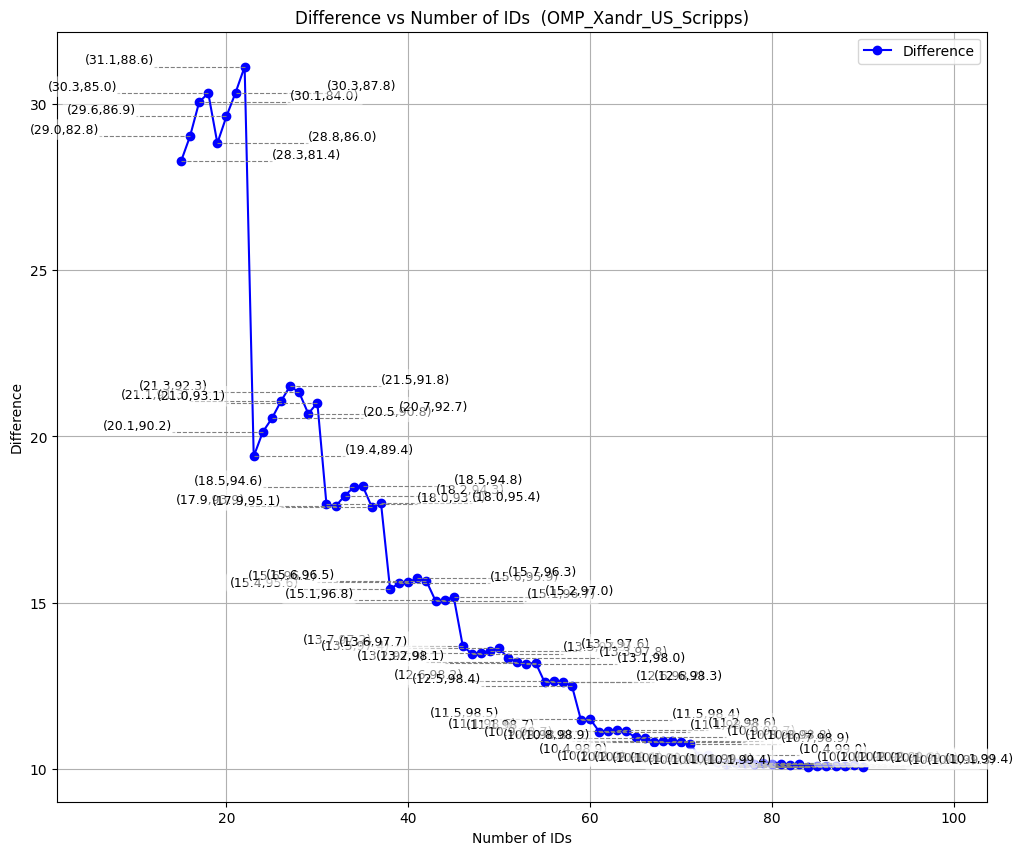

In [ ]:
# We plot ('Index',  'Difference') to see the optimal point, Index = Number of Bundle IDs
# Point on chart: (Differnce, revenue_pct)

# Consider the Bidder in the list
n=1

# Get data
result_numeric = check(n).copy()


# First threshold, we need to retain at least 80% of Revenue, and difference >10%
result_numeric=result_numeric[(result_numeric['revenue_pct']>80)&(result_numeric['difference']>10)]

# Plotting
plt.figure(figsize=(12, 10))
plt.plot(result_numeric['index'], result_numeric['difference'], marker='o', linestyle='-', color='b', label='Difference')
# Plot each point with its value and connector lines
for i in range(len(result_numeric)):
    # Determine position
    ha = 'left' if i % 2 == 0 else 'right'
    dx = 10 if ha == 'left' else -10
    # connector line
    plt.text(result_numeric['index'].iloc[i] + dx, result_numeric['difference'].iloc[i],
             f'({result_numeric["difference"].iloc[i]:.1f},{result_numeric["revenue_pct"].iloc[i]:.1f})',
             fontsize=9, ha=ha, va='bottom', color='black',
             bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3', alpha=0.5))
    plt.plot([result_numeric['index'].iloc[i], result_numeric['index'].iloc[i] + dx],
             [result_numeric['difference'].iloc[i], result_numeric['difference'].iloc[i]],
             linestyle='--', color='gray', linewidth=0.8)

plt.title(f'Difference vs Number of IDs  ({list_of_bidder[n]})')
plt.xlabel('Number of IDs')
plt.ylabel('Difference')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
# Check and view the optimal point for each Biddername
percent_of_revenue_to_check = [90.2,88.6]

# First get the dataframe < 'optimal revenue_pct', then we need 1 row more to guarantee the optimal point included,
# using <= 'optimal revenue_pct' is not efficient with rounding and we need to choose exactly the point
To_get_index = result_numeric[result_numeric['revenue_pct']< percent_of_revenue_to_check[n]]
df_above_1 = result_numeric[result_numeric['revenue_pct'] >= percent_of_revenue_to_check[n]].head(1)

# To later highlight the optimal point and  'max index' for plotting purposes
To_get_index = pd.concat([To_get_index, df_above_1])
highlight_index = To_get_index.shape[0]-1
max_index = result_numeric.shape[0]-1

# To view the dataframe after having the optimal points using K, M, % ...
# We will use this function to get all 'Bundle IDs to remove' for all biddername
# We need two functions check(n) and view(n) because for view(n) we use K, M, % so datatype = String
def view(n):
  # Calculate again for each bidder
  result=check(n).copy()

  # We need this part again for the loop over all biddername, if we use this similar block of code outside the funciton so does not work for the loop
  # If we use this block of code only inside the function so we can not use the index of optimal point for plotting purposes
  To_get_index = result[result['revenue_pct']< percent_of_revenue_to_check[n]]
  df_above_1 = result[result['revenue_pct'] >= percent_of_revenue_to_check[n]].head(1)
  To_get_index = pd.concat([To_get_index, df_above_1])
  highlight_index = To_get_index.shape[0]-1
  max_index = result.shape[0]-1

  # For better view with K, M, % and Rounding
  result['impressions']=result['impressions'].astype(int).apply(lambda x: f"{x/1000:.0f}K" if abs(x) >= 1000 else f"{x:.0f}")
  result['bid_requests']=result['bid_requests'].apply(lambda x: f"{x/1000000:.0f}M" if abs(x) >= 1000000 else f"{x:.0f}")
  result['cumulative_req']=result['cumulative_req'].apply(lambda x: f"{x/1000000:.0f}M" if abs(x) >= 1000000 else f"{x:.0f}")
  result['revenue_pct'] = result['revenue_pct'].apply(lambda x: f"{x:.1f}%")
  result['requests_pct'] = result['requests_pct'].apply(lambda x: f"{x:.1f}%")
  result['difference'] = result['difference'].apply(lambda x: f"{x:.1f}%")
  result['gross_revenue ($)'] = result['gross_revenue ($)'].apply(lambda x: f"${x:.0f}")
  result['cumulative_rev'] = result['cumulative_rev'].apply(lambda x: f"${x:.0f}")

  # Define the status for keeping or removing Bundle IDs based on the index of the optimal point: highlight_index
  # highlight_index is a normal index from 0, while for 'Index' we calculate from 1 so we +1 to have the same value
  result['Status'] = np.where(result['index']<=highlight_index+1, 'To keep', 'To remove')
  return result

view(n)

,biddername,app_bundle_id,bid_requests,impressions,gross_revenue ($),index,cumulative_rev,revenue_pct,cumulative_req,requests_pct,difference,Status
23,OMP_Xandr_US_Scripps,com.calkins.wral,19M,69K,$1381,1,$1381,27.9%,19M,2.0%,25.8%,To keep
12,OMP_Xandr_US_Scripps,474301,35M,37K,$580,2,$1961,39.6%,54M,5.7%,33.9%,To keep
2,OMP_Xandr_US_Scripps,G15147002586,325M,20K,$316,3,$2277,46.0%,379M,39.8%,6.2%,To keep
93,OMP_Xandr_US_Scripps,166590,2M,17K,$296,4,$2574,52.0%,381M,40.0%,12.0%,To keep
119,OMP_Xandr_US_Scripps,90570,2M,9K,$207,5,$2780,56.1%,383M,40.2%,16.0%,To keep
...,...,...,...,...,...,...,...,...,...,...,...,...
502,OMP_Xandr_US_Scripps,web.localnow,26491,0,$0,334,$4953,100.0%,953M,100.0%,0.0%,To remove
503,OMP_Xandr_US_Scripps,ccom.tribtv.wxmi,26264,0,$0,335,$4953,100.0%,953M,100.0%,0.0%,To remove
515,OMP_Xandr_US_Scripps,com.nuvyyo.tablotv,23119,0,$0,336,$4953,100.0%,953M,100.0%,0.0%,To remove
517,OMP_Xandr_US_Scripps,B0BL8HQ3FM,22734,0,$0,337,$4953,100.0%,953M,100.0%,0.0%,To remove


In [ ]:
# We get the list of all 'Bundle IDs to remove' over all biddername

# First start with empty
List_bundle_to_remove= []

# Loop over all biddername
for n in range(len(list_of_bidder)):
  # Get the dataframe from view(n) function
  Test_df= view(n).copy()

  # Get the 'To remove' Bundle IDs for current biddername
  Test_list = Test_df[Test_df['Status']=='To remove'].app_bundle_id.unique()

  # Append the result to the list List_bundle_to_remove
  List_bundle_to_remove.append(Test_list)

# Import List_bundle_to_remove into dataframe
df_to_remove = pd.DataFrame(List_bundle_to_remove).T  # .T is used to transpose so that arrays become columns
df_to_remove.columns =list_of_bidder

df_to_remove

,OMP_Magnite_US_Scripps,OMP_Xandr_US_Scripps
0,com.xumo.comcastflex,com.xumo.comcastflex
1,B004Y1WCDE,575918
2,91628,B07795KM4Q
3,fubo.firetv.screen,90567
4,B01J62Q632,565973
...,...,...
311,None,web.localnow
312,None,ccom.tribtv.wxmi
313,None,com.nuvyyo.tablotv
314,None,B0BL8HQ3FM


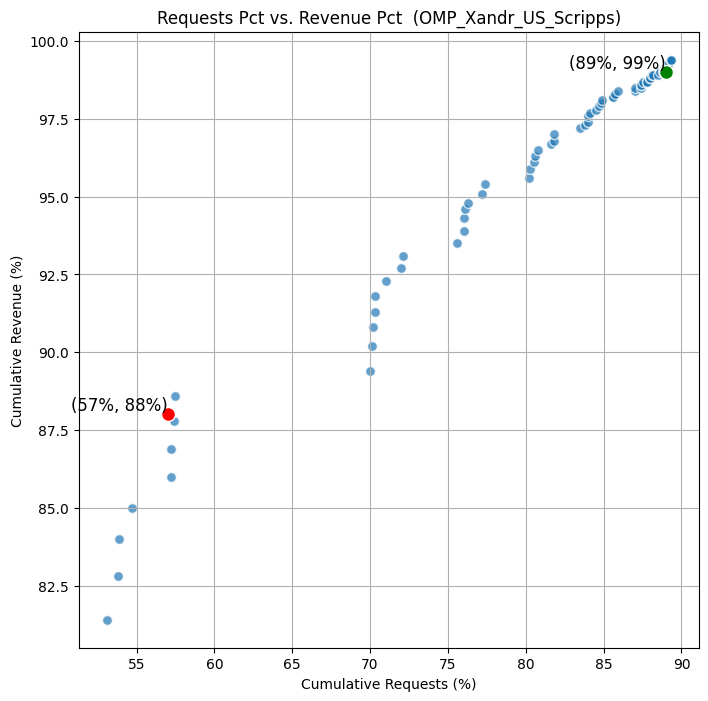

In [ ]:
# To plot all points and highlight the optimal (red) and the max (green)
# Point: (x,y) = (requests_pct, revenue_pct)

plt.figure(figsize=(8, 8))
plt.scatter(result_numeric['requests_pct'], result_numeric['revenue_pct'], alpha=0.7, edgecolors='w', s=50)
plt.xlabel('Cumulative Requests (%)')
plt.ylabel('Cumulative Revenue (%)')
plt.title(f'Requests Pct vs. Revenue Pct  ({list_of_bidder[n]})')
highlight_value_x = int(result_numeric['requests_pct'].iloc[highlight_index])
highlight_value_y = int(result_numeric['revenue_pct'].iloc[highlight_index])
plt.scatter(highlight_value_x, highlight_value_y, color='red', edgecolors='w', s=100, label='Highlighted Point')
plt.text(highlight_value_x, highlight_value_y, f'({highlight_value_x}%, {highlight_value_y}%)', fontsize=12, color='black',
         ha='right', va='bottom')
highlight_value_x_max = int(result_numeric['requests_pct'].iloc[max_index])
highlight_value_y_max = int(result_numeric['revenue_pct'].iloc[max_index])
plt.scatter(highlight_value_x_max, highlight_value_y_max, color='green', edgecolors='w', s=100, label='Highlighted Point')
plt.text(highlight_value_x_max, highlight_value_y_max, f'({highlight_value_x_max}%, {highlight_value_y_max}%)', fontsize=12, color='black',
         ha='right', va='bottom')
plt.grid(True)
plt.show()

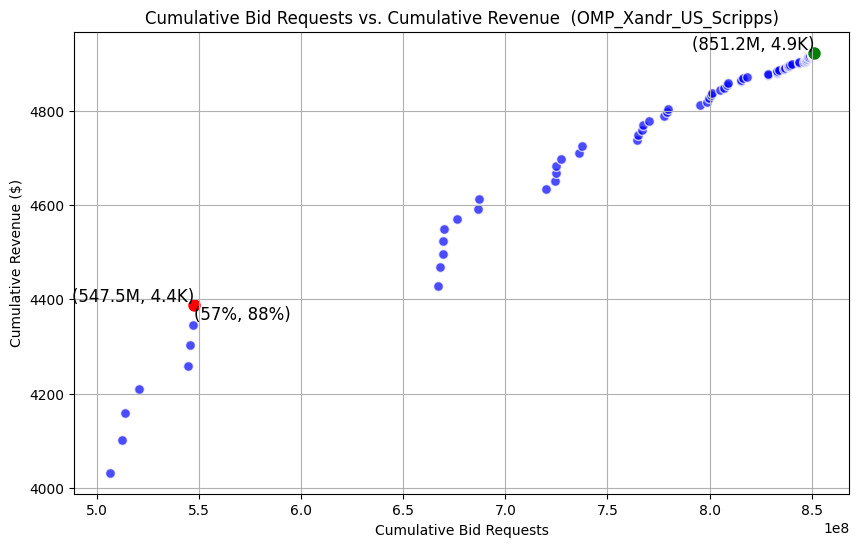

In [ ]:
# Plot 2, to see absolute values, we simplify the view with 'B', 'M', 'K' using the bewlow function
def format_number(value, unit=''):
    """Formats a large number with suffixes 'M' for millions and 'B' for billions."""
    if value >= 1_000_000_000:
        return f'{value / 1_000_000_000:.1f}B'
    elif value >= 1_000_000:
        return f'{value / 1_000_000:.1f}M'
    else:
        return f'{value / 1_000:.1f}K'

# Plotting (x,y) = (cumulative_req, cumulative_rev)
# Highlighting optimal (red) and the max point (green). (requests_pct, revenue_pct) is added to the optimal point
plt.figure(figsize=(10, 6))
plt.scatter(result_numeric['cumulative_req'], result_numeric['cumulative_rev'], alpha=0.7, edgecolors='w', s=50, c='blue')
plt.xlabel('Cumulative Bid Requests')
plt.ylabel('Cumulative Revenue ($)')
plt.title(f'Cumulative Bid Requests vs. Cumulative Revenue  ({list_of_bidder[n]})')
highlight_value_x_2 = result_numeric['cumulative_req'].iloc[highlight_index]
highlight_value_y_2 = int(result_numeric['cumulative_rev'].iloc[highlight_index])
plt.scatter(highlight_value_x_2, highlight_value_y_2, color='red', edgecolors='w', s=100, label='Highlighted Point')
plt.text(highlight_value_x_2, highlight_value_y_2, f'({format_number(highlight_value_x_2)}, {format_number(highlight_value_y_2)})', fontsize=12, color='black',
         ha='right', va='bottom')
highlight_value_x_max2 = result_numeric['cumulative_req'].iloc[max_index]
highlight_value_y_max2 = int(result_numeric['cumulative_rev'].iloc[max_index])
plt.scatter(highlight_value_x_max2, highlight_value_y_max2, color='green', edgecolors='w', s=100, label='Highlighted Point')
plt.text(highlight_value_x_max2, highlight_value_y_max2, f'({format_number(highlight_value_x_max2)}, {format_number(highlight_value_y_max2)})', fontsize=12, color='black',
         ha='right', va='bottom')
plt.text(highlight_value_x_2, highlight_value_y_2, f'({highlight_value_x}%, {highlight_value_y}%)', fontsize=12, color='black',
         ha='left', va='top')
plt.grid(True)

plt.show()


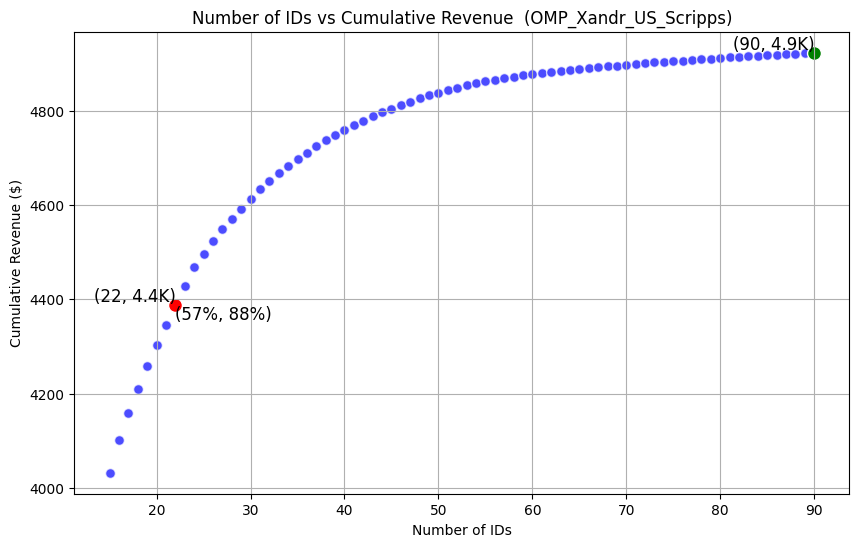

In [ ]:
# Plotting 3, to see number of Bundler IDs in correlation with cummulative revenue
# Point (x,y) = ('Index', 'cumulative_rev')
# The optimal point (red), The max point (green). (requests_pct, revenue_pct) is also added to the optimal point

plt.figure(figsize=(10, 6))
plt.scatter(result_numeric['index'], result_numeric['cumulative_rev'], alpha=0.7, edgecolors='w', s=50, c='blue')
plt.xlabel('Number of IDs')
plt.ylabel('Cumulative Revenue ($)')
plt.title(f'Number of IDs vs Cumulative Revenue  ({list_of_bidder[n]})')
highlight_value_x_3 = result_numeric['index'].iloc[highlight_index]
highlight_value_y_3 = int(result_numeric['cumulative_rev'].iloc[highlight_index])
plt.scatter(highlight_value_x_3, highlight_value_y_3, color='red', edgecolors='w', s=100, label='Highlighted Point')
plt.text(highlight_value_x_3, highlight_value_y_3, f'({highlight_value_x_3}, {format_number(highlight_value_y_3)})', fontsize=12, color='black',
         ha='right', va='bottom')
highlight_value_x_max3 = result_numeric['index'].iloc[max_index]
highlight_value_y_max3 = int(result_numeric['cumulative_rev'].iloc[max_index])
plt.scatter(highlight_value_x_max3, highlight_value_y_max3, color='green', edgecolors='w', s=100, label='Max Point')
plt.text(highlight_value_x_max3, highlight_value_y_max3, f'({highlight_value_x_max3}, {format_number(highlight_value_y_max3)})', fontsize=12, color='black',
         ha='right', va='bottom')
plt.text(highlight_value_x_3, highlight_value_y_3, f'({highlight_value_x}%, {highlight_value_y}%)', fontsize=12, color='black',
         ha='left', va='top')
plt.grid(True)
plt.show()

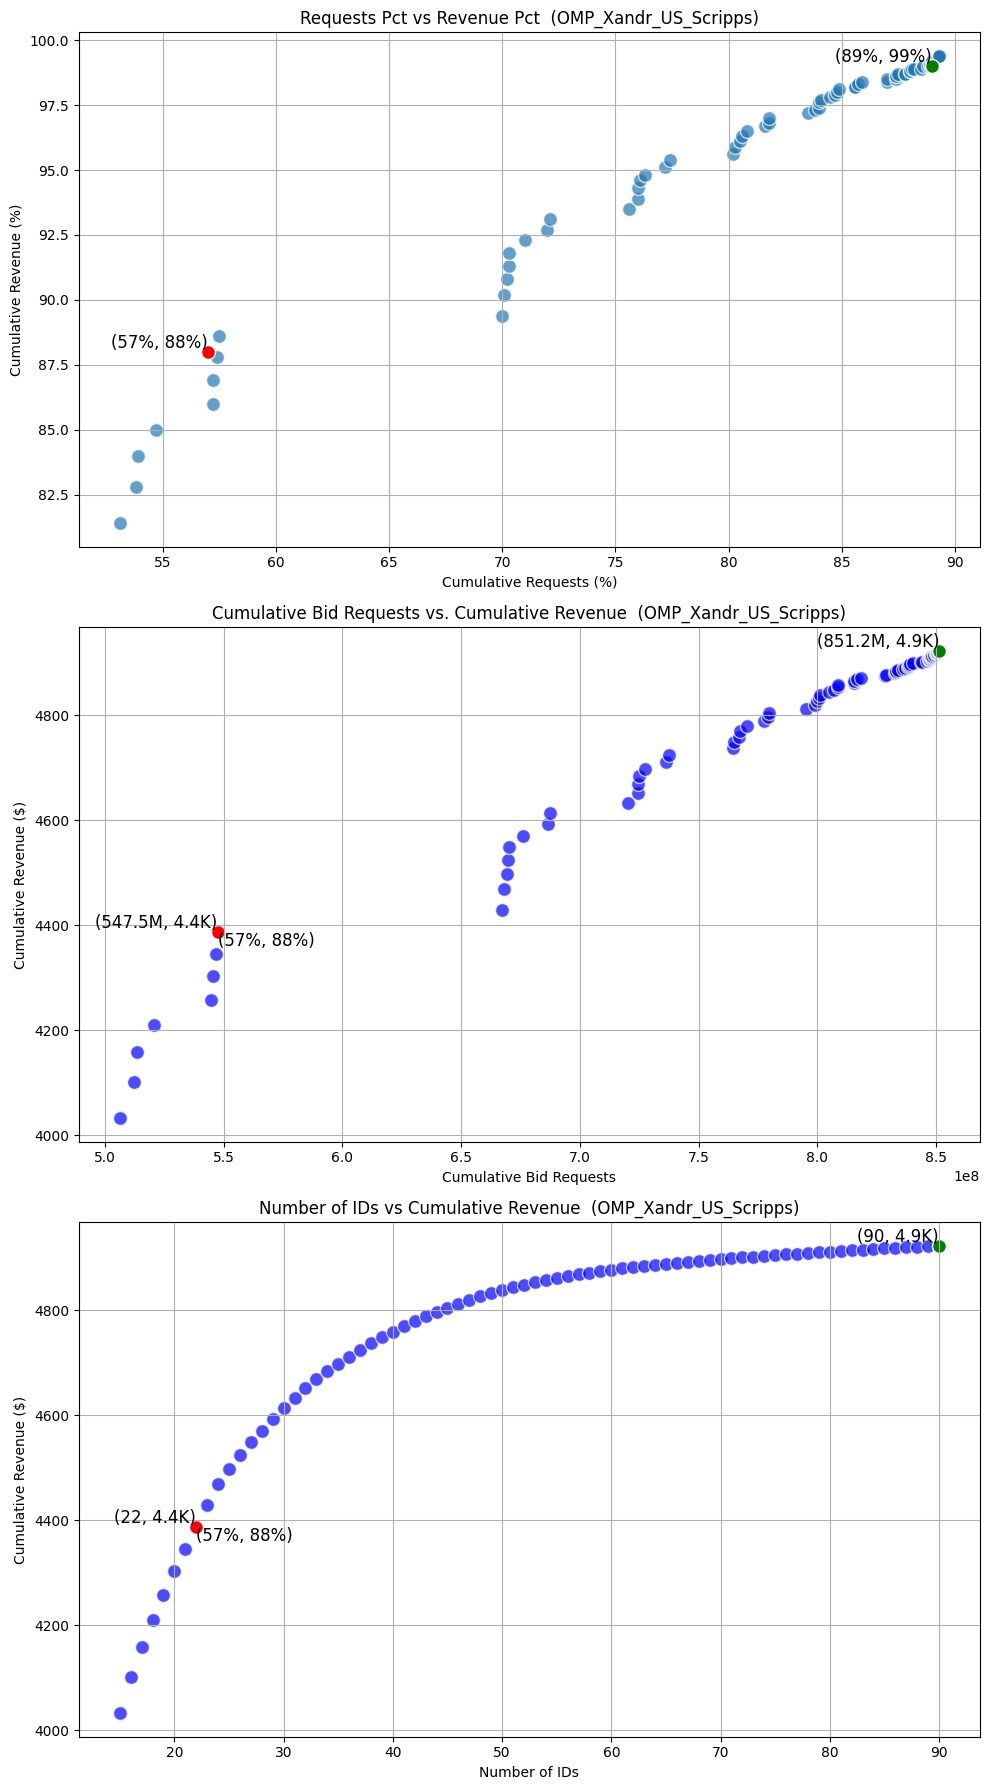

In [ ]:
# Similarly to all three above charts, but we run all in one

fig, axs = plt.subplots(3, 1, figsize=(10, 18))
# Plot1
axs[0].scatter(result_numeric['requests_pct'], result_numeric['revenue_pct'], alpha=0.7, edgecolors='w', s=100)
axs[0].set_xlabel('Cumulative Requests (%)')
axs[0].set_ylabel('Cumulative Revenue (%)')
axs[0].set_title(f'Requests Pct vs Revenue Pct  ({list_of_bidder[n]})')
highlight_value_x = int(result_numeric['requests_pct'].iloc[highlight_index])
highlight_value_y = int(result_numeric['revenue_pct'].iloc[highlight_index])
axs[0].scatter(highlight_value_x_max, highlight_value_y_max, color='green', edgecolors='w', s=100, label='Highlighted Point')
axs[0].text(highlight_value_x_max, highlight_value_y_max, f'({highlight_value_x_max}%, {highlight_value_y_max}%)', fontsize=12, color='black',
         ha='right', va='bottom')
axs[0].scatter(highlight_value_x, highlight_value_y, color='red', edgecolors='w', s=100, label='Highlighted Point')
axs[0].text(highlight_value_x, highlight_value_y, f'({highlight_value_x}%, {highlight_value_y}%)', fontsize=12, color='black',
         ha='right', va='bottom')
axs[0].grid(True)

# Plot2
axs[1].scatter(result_numeric['cumulative_req'], result_numeric['cumulative_rev'], alpha=0.7, edgecolors='w', s=100, c='blue')
axs[1].set_xlabel('Cumulative Bid Requests')
axs[1].set_ylabel('Cumulative Revenue ($)')
axs[1].set_title(f'Cumulative Bid Requests vs. Cumulative Revenue  ({list_of_bidder[n]})')
highlight_value_x_2 = result_numeric['cumulative_req'].iloc[highlight_index]
highlight_value_y_2 = int(result_numeric['cumulative_rev'].iloc[highlight_index])
axs[1].scatter(highlight_value_x_2, highlight_value_y_2, color='red', edgecolors='w', s=100, label='Highlighted Point')
axs[1].text(highlight_value_x_2, highlight_value_y_2, f'({format_number(highlight_value_x_2)}, {format_number(highlight_value_y_2)})', fontsize=12, color='black',
         ha='right', va='bottom')
axs[1].text(highlight_value_x_2, highlight_value_y_2, f'({highlight_value_x}%, {highlight_value_y}%)', fontsize=12, color='black',
         ha='left', va='top')
highlight_value_x_max2 = result_numeric['cumulative_req'].iloc[max_index]
highlight_value_y_max2 = int(result_numeric['cumulative_rev'].iloc[max_index])
axs[1].scatter(highlight_value_x_max2, highlight_value_y_max2, color='green', edgecolors='w', s=100, label='Highlighted Point')
axs[1].text(highlight_value_x_max2, highlight_value_y_max2, f'({format_number(highlight_value_x_max2)}, {format_number(highlight_value_y_max2)})', fontsize=12, color='black',
         ha='right', va='bottom')
axs[1].grid(True)

# Plot3
axs[2].scatter(result_numeric['index'], result_numeric['cumulative_rev'], alpha=0.7, edgecolors='w', s=100, c='blue')
axs[2].set_xlabel('Number of IDs')
axs[2].set_ylabel('Cumulative Revenue ($)')
axs[2].set_title(f'Number of IDs vs Cumulative Revenue  ({list_of_bidder[n]})')
highlight_value_x_3 = result_numeric['index'].iloc[highlight_index]
highlight_value_y_3 = int(result_numeric['cumulative_rev'].iloc[highlight_index])
axs[2].scatter(highlight_value_x_3, highlight_value_y_3, color='red', edgecolors='w', s=100, label='Highlighted Point')
axs[2].text(highlight_value_x_3, highlight_value_y_3, f'({highlight_value_x_3}, {format_number(highlight_value_y_3)})', fontsize=12, color='black',
         ha='right', va='bottom')
axs[2].text(highlight_value_x_3, highlight_value_y_3, f'({highlight_value_x}%, {highlight_value_y}%)', fontsize=12, color='black',
         ha='left', va='top')
highlight_value_x_max3 = result_numeric['index'].iloc[max_index]
highlight_value_y_max3 = int(result_numeric['cumulative_rev'].iloc[max_index])
axs[2].scatter(highlight_value_x_max3, highlight_value_y_max3, color='green', edgecolors='w', s=100, label='Max Point')
axs[2].text(highlight_value_x_max3, highlight_value_y_max3, f'({highlight_value_x_max3}, {format_number(highlight_value_y_max3)})', fontsize=12, color='black',
         ha='right', va='bottom')
axs[2].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()